## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Undestort Image
---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from utils.CameraCalibration import CameraCalibration # import Calibaration

In [3]:
# Make a list of calibration images
chkboard_images = glob.glob('./camera_cal/calibration*.jpg')

# 
calibration = CameraCalibration(chkboard_images)

In [4]:
calibration.mtx, calibration.dist

(array([[  1.15777829e+03,   0.00000000e+00,   6.67113866e+02],
        [  0.00000000e+00,   1.15282230e+03,   3.86124658e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[-0.24688572, -0.02372824, -0.00109832,  0.00035104, -0.00260433]]))

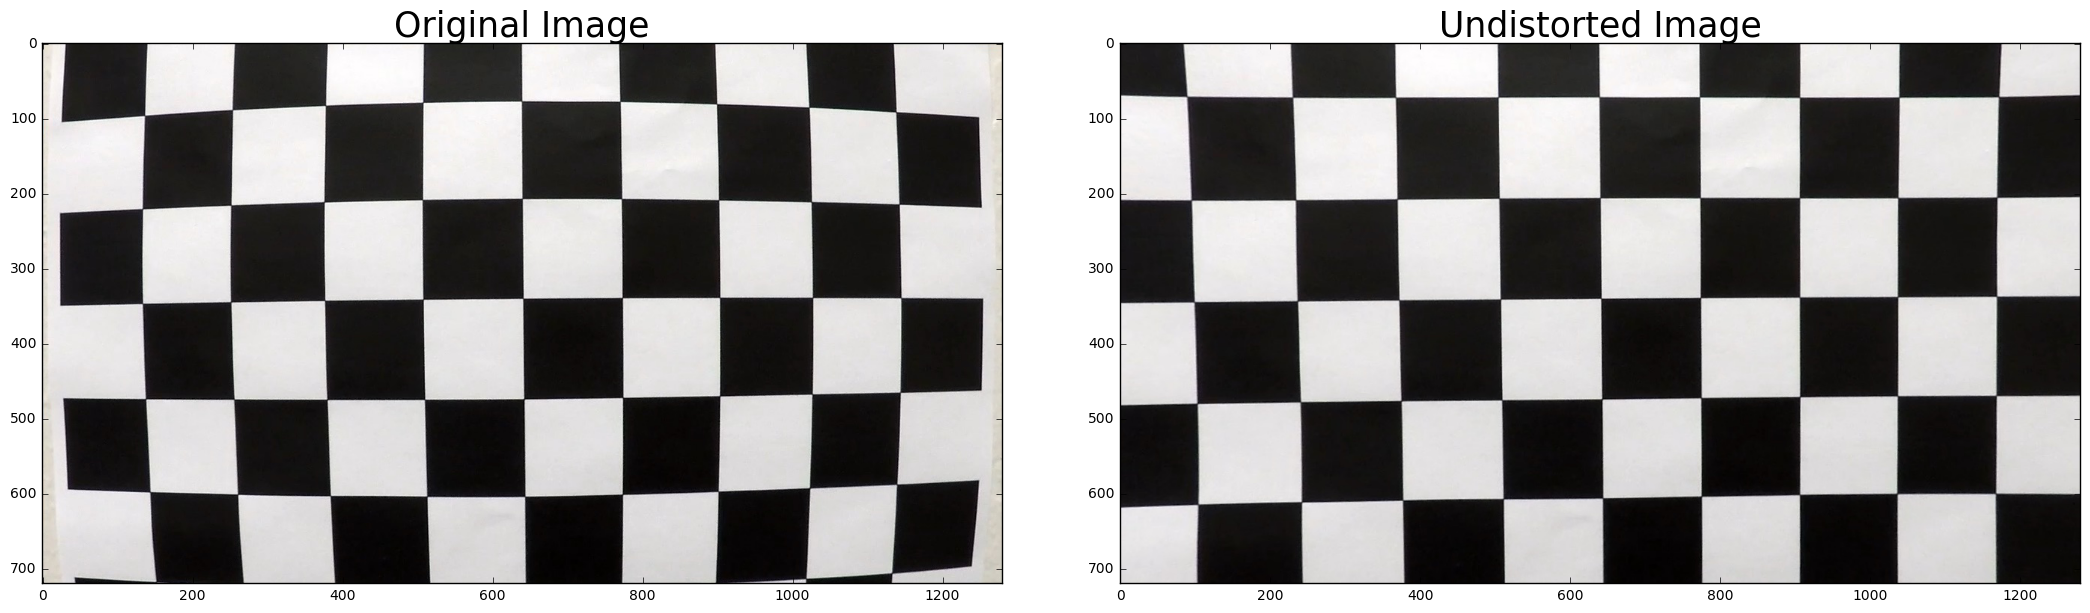

In [5]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undimg = calibration.undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undimg)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Image Thresholding
---
Thresholding: using HLS channel

In [6]:
from utils.Thresholding import ImageColorThres

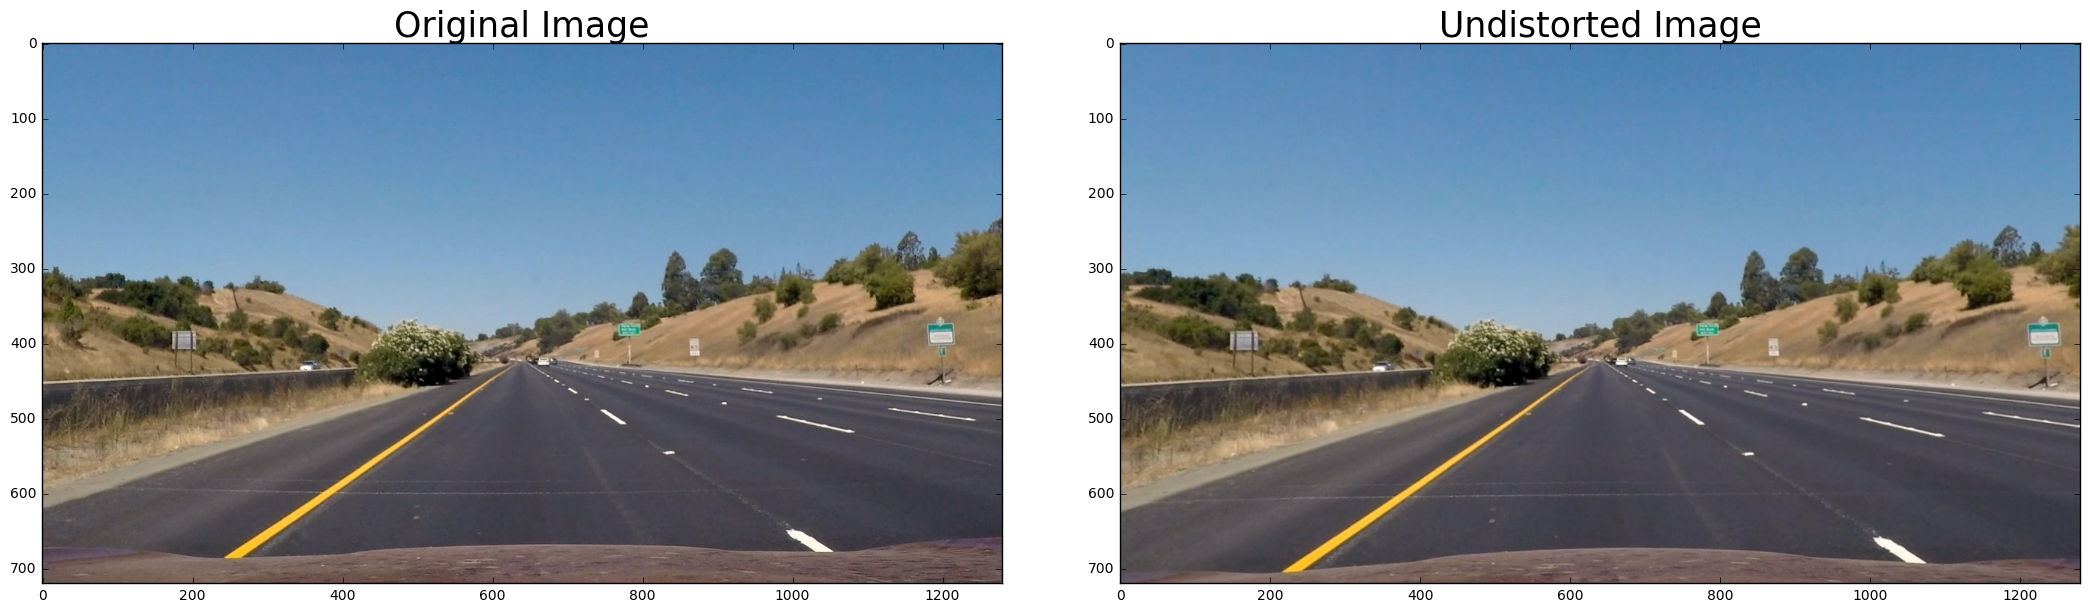

In [7]:
# load road image
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image from BGR to RGB

undimg = calibration.undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undimg)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
imshape = undimg.shape # image size
print("image shape: ", imshape)

roi_vertices = np.array([[(0,imshape[0]), 
                        (imshape[1]*7/15, imshape[0]*3/5), 
                        (imshape[1]*8/15, imshape[0]*3/5), 
                        (imshape[1],imshape[0])]], 
                         dtype=np.int32) # vertices of roi

colorthres = ImageColorThres(img, roi_vertices)

image shape:  (720, 1280, 3)
color thresholding class2


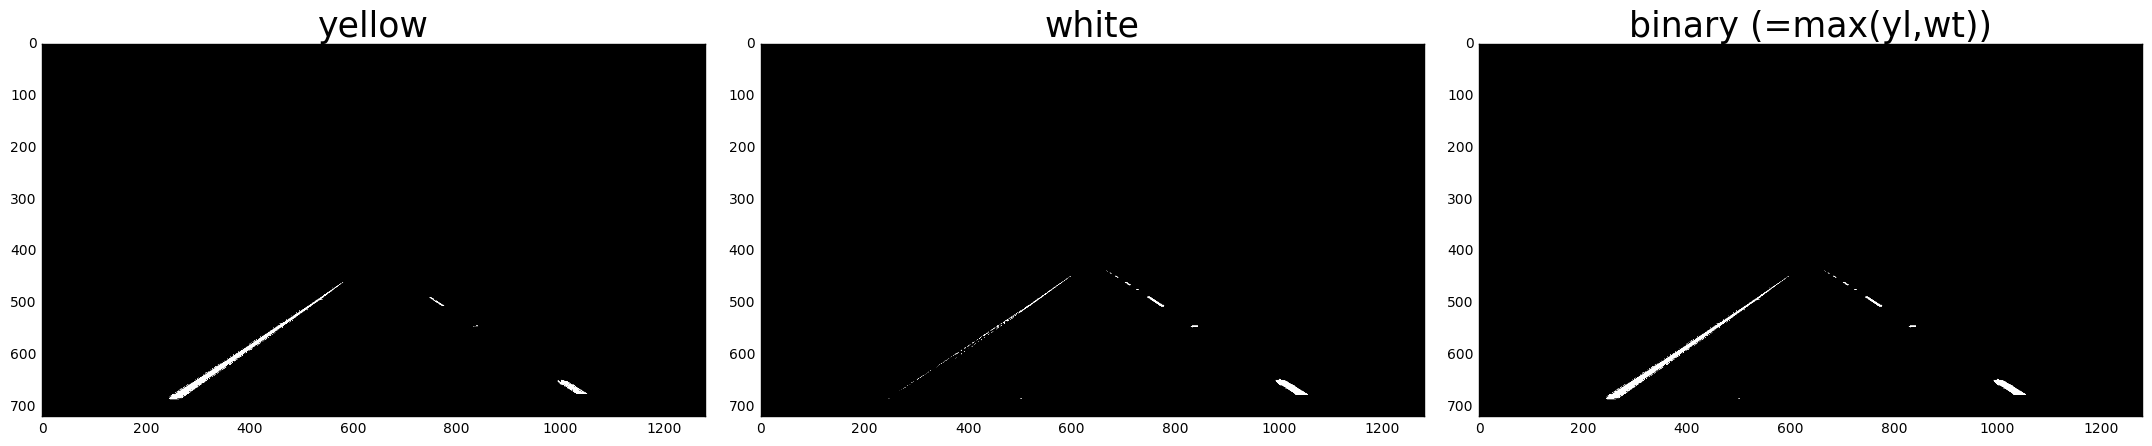

In [9]:
yellowline = colorthres.thresholding_onechannel('S', 150, 255) # yellow for S channel
whiteline  = colorthres.thresholding_onechannel('L', 170, 255) # white for L channel

binary_color = np.zeros_like(yellowline)
binary_color = np.maximum(yellowline, whiteline) # combine white and yellow using maximum

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
f.tight_layout()
ax1.imshow(yellowline, cmap='gray')
ax1.set_title('yellow', fontsize=25)
ax2.imshow(whiteline, cmap='gray')
ax2.set_title('white', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(binary_color, cmap='gray')
ax3.set_title('binary (=max(yl,wt))', fontsize=25)

## Gradient Filter
---
using sobel operator

In [19]:
import utils.GradientThresholding as gradThres

In [20]:
redimg = undimg[:,:,0]

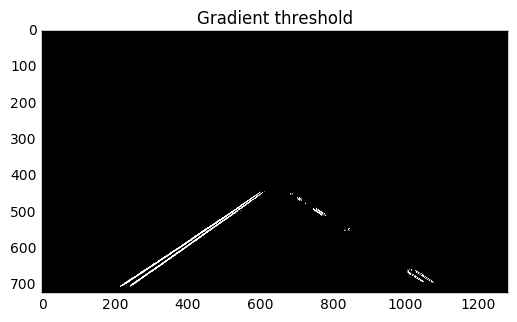

In [27]:
# Choose a Sobel kernel size
ksize = 11 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = gradThres.abs_sobel_thresh(redimg, orient='x', sobel_kernel=ksize, thresh=(50, 200))
grady = gradThres.abs_sobel_thresh(redimg, orient='y', sobel_kernel=ksize, thresh=(50, 200))

# Combine gradient and trim roi
combined = np.zeros_like(gradx)
combined[((gradx == 1) & (grady == 1))] = 1
binary_grad = gradThres.region_of_interest(combined, roi_vertices)

# plot result
plt.imshow(binary_grad, cmap='gray')
plt.title('Gradient threshold')

## Combine color thresholds and gradient thresholds

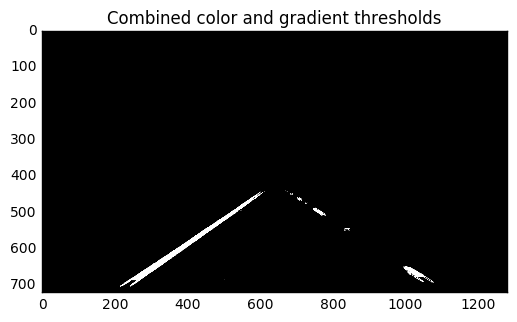

In [25]:
finimg = np.zeros_like(redimg)
finimg[(binary_grad == 1) | (binary_color ==1)] = 1
plt.imshow(finimg, cmap='gray')
plt.title('Combined color and gradient thresholds')

## Perspective Transform
---
Compute the perspective transform, M, given source and destination points:

```
M = cv2.getPerspectiveTransform(src, dst)
```

In [ ]:
undimg = calibration.undistort_img(img)

image shape: (720, 1280)
[[580, 460], [710, 460], [1150, 720], [150, 720]]


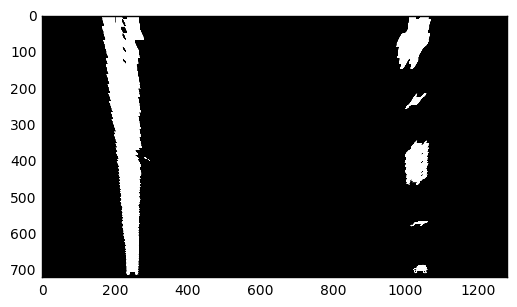

In [28]:
# Define image shape
image_shape = finimg.shape
print("image shape:",image_shape)
# Define the region
area_of_interest = [[580,460],[710,460],[1150,720],[150,720]]
print(area_of_interest)

# Choose an offset from image corners to plot detected corners
offset1 = 200 # offset for dst points x value
offset2 = 0 # offset for dst points bottom y value
offset3 = 0 # offset for dst points top y value

# Grab the image shape
img_size = (finimg.shape[1], finimg.shape[0])

# For source points I'm grabbing the outer four detected corners
src = np.float32(area_of_interest)

# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
dst = np.float32([[offset1, offset3], 
                  [img_size[0]-offset1, offset3], 
                  [img_size[0]-offset1, img_size[1]-offset2], 
                  [offset1, img_size[1]-offset2]])

# calculate perspective transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# warp the image 
binary_warped = cv2.warpPerspective(finimg, M, img_size)

# plot
plt.imshow(binary_warped, cmap='gray')
plt.show()

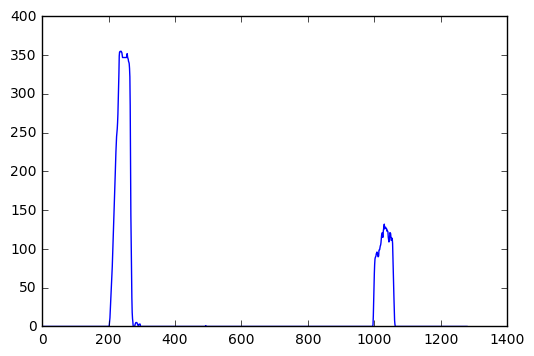

In [29]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [30]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

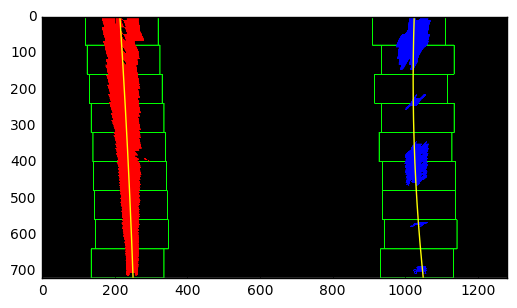

In [31]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Skip the sliding windows step once you know where the lines are
Now you know where the lines are you have a fit! In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous line position like this:

In [32]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

### And you're done! But let's visualize the result here as well

(720, 0)

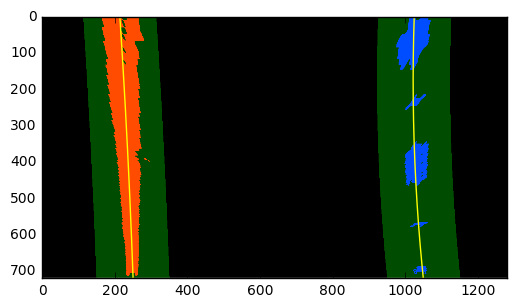

In [33]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Tracking

In [34]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None

### Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:


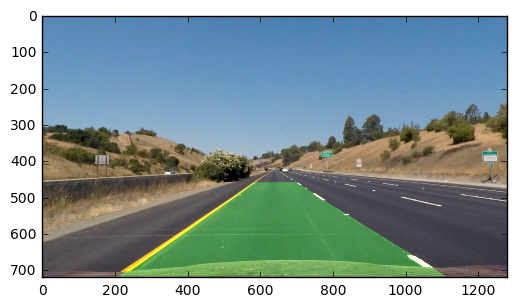

In [35]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undimg.shape[1], undimg.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undimg, 1, newwarp, 0.3, 0)
plt.imshow(result)